In [1]:
from dataset import SceneTextDataset
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import os.path as osp
from imageio import imread




%load_ext autoreload
%autoreload 2
%matplotlib inline


캠퍼들이 annotation한 이미지에 bbox 그리기

In [2]:
def draw_bbox(image, bbox, color=(0, 0, 255), thickness=1, thickness_sub=None, double_lined=False,
              write_point_numbers=False):
    thickness_sub = thickness_sub or thickness * 3
    basis = max(image.shape[:2])
    fontsize = basis / 1500
    x_offset, y_offset = int(fontsize * 12), int(fontsize * 10)
    color_sub = (255 - color[0], 255 - color[1], 255 - color[2])

    points = [(int(np.rint(p[0])), int(np.rint(p[1]))) for p in bbox]

    for idx in range(len(points)):
        if double_lined:
            cv2.line(image, points[idx], points[(idx + 1) % len(points)], color_sub,
                     thickness=thickness_sub)
        cv2.line(image, points[idx], points[(idx + 1) % len(points)], color, thickness=thickness)

    if write_point_numbers:
        for idx in range(len(points)):
            loc = (points[idx][0] - x_offset, points[idx][1] - y_offset)
            if double_lined:
                cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color_sub,
                            thickness_sub, cv2.LINE_AA)
            cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color, thickness,
                        cv2.LINE_AA)


def draw_bboxes(image, bboxes, color=(0, 0, 255), thickness=1, thickness_sub=None,
                double_lined=False, write_point_numbers=False):
    for bbox in bboxes:
        draw_bbox(image, bbox, color=color, thickness=thickness, thickness_sub=thickness_sub,
                  double_lined=double_lined, write_point_numbers=write_point_numbers)
        

def gray_mask_to_heatmap(x):
    x = cv2.cvtColor(cv2.applyColorMap(x, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
    return x


def get_superimposed_image(image, score_map, heatmap=True, w_image=None, w_map=None):
    """
    Args:
        image (ndarray): (H, W, C) shaped, float32 or uint8 dtype is allowed.
        score_map (ndarray): (H, W) shaped, float32 or uint8 dtype is allowed.
        heatmap (boot): Wheather to convert `score_map` into a heatmap.
        w_image (float)
        w_map (float)

    Blending weights(`w_image` and `w_map`) are default to (0.4, 0.6).
    """

    assert w_image is None or (w_image > 0 and w_image < 1)
    assert w_map is None or (w_map > 0 and w_map < 1)

    if image.dtype != np.uint8:
        image = (255 * np.clip(image, 0, 1)).astype(np.uint8)

    if score_map.dtype != np.uint8:
        score_map = (255 * np.clip(score_map, 0, 1)).astype(np.uint8)
    if heatmap:
        score_map = gray_mask_to_heatmap(score_map)
    elif score_map.ndim == 2 or score_map.shape[2] != 3:
        score_map = cv2.cvtColor(score_map, cv2.COLOR_GRAY2RGB)

    if w_image is None and w_map is None:
        w_image, w_map = 0.4, 0.6
    elif w_image is None:
        w_image = 1 - w_map
    elif w_map is None:
        w_map = 1 - w_image

    return cv2.addWeighted(image, w_image, score_map, w_map, 0)

In [3]:
DATASET_DIR = '/opt/ml/input/data/upstage_IC17+IC19_Korean'  # FIXME

ufo_fpath = osp.join(DATASET_DIR, 'ufo/train.json')
with open(ufo_fpath, 'r') as f:
    ufo_anno = json.load(f)

sample_ids_sorted = sorted(ufo_anno['images'])
sample_ids = list(ufo_anno['images'])


1604828077798-0.jpg
Image:	(898, 960, 3)
Bboxes:	(11, 4, 2)
Labels:	(11,)


/tmp/ipykernel_31274/4060009002.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(image_fpath)


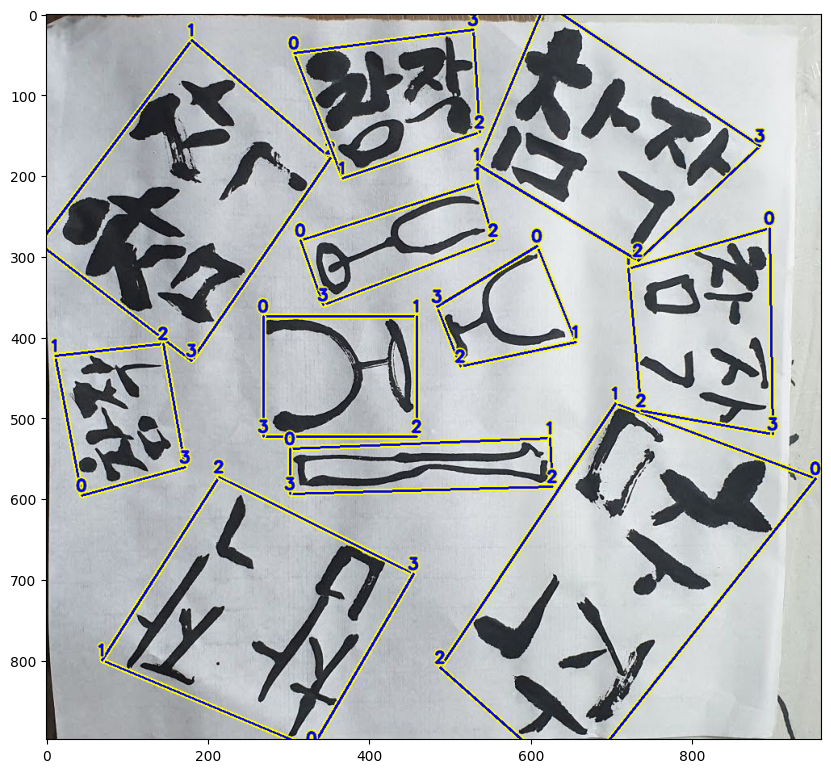

In [10]:
SAMPLE_IDX = 11

#sample_id = sample_ids[SAMPLE_IDX]
sample_id = sample_ids_sorted[SAMPLE_IDX]
print(sample_id)
image_fpath = osp.join(DATASET_DIR, 'images', sample_id)
image = imread(image_fpath)

print('Image:\t{}'.format(image.shape))

bboxes, labels = [], []
for word_info in ufo_anno['images'][sample_id]['words'].values():
    bboxes.append(np.array(word_info['points']))
    labels.append(int(not word_info['illegibility']))
bboxes, labels = np.array(bboxes, dtype=np.float32), np.array(labels, dtype=np.float32)

print('Bboxes:\t{}'.format(bboxes.shape))
print('Labels:\t{}'.format(labels.shape))

vis = image.copy()
draw_bboxes(vis, bboxes, double_lined=True, thickness=2, thickness_sub=5, write_point_numbers=True)

plt.figure(figsize=(10, 10))
plt.imshow(vis)

#print(len(sample_ids_sorted))

In [86]:
ufo_anno['images'][sample_id]['words']


{'0': {'points': [[1308.0, 380.0],
   [2150.0, 376.0],
   [2160.0, 588.0],
   [1316.0, 559.0]],
  'transcription': '###',
  'language': ['ko'],
  'illegibility': True,
  'orientation': 'Horizontal',
  'word_tags': None},
 '1': {'points': [[718.0, 140.0],
   [1545.0, 133.0],
   [1550.0, 365.0],
   [710.0, 373.0]],
  'transcription': '알바구함',
  'language': ['ko'],
  'illegibility': False,
  'orientation': 'Horizontal',
  'word_tags': None},
 '2': {'points': [[229.0, 663.0],
   [685.0, 663.0],
   [687.0, 788.0],
   [224.0, 792.0]],
  'transcription': '주방에서',
  'language': ['ko'],
  'illegibility': False,
  'orientation': 'Horizontal',
  'word_tags': None},
 '3': {'points': [[743.0, 652.0],
   [964.0, 656.0],
   [972.0, 799.0],
   [741.0, 795.0]],
  'transcription': '함께',
  'language': ['ko'],
  'illegibility': False,
  'orientation': 'Horizontal',
  'word_tags': None},
 '4': {'points': [[1038.0, 670.0],
   [1484.0, 663.0],
   [1484.0, 788.0],
   [1041.0, 788.0]],
  'transcription': '일하실분',